# 宏观因子资产配置研究

更新日志
- 2022.10.22 
  - 梳理工作内容并搭建研究框架
- 10.24
  - 计算因子暴露和因子模拟组合
- 11.16
  - 计算因子（常规、PCA）
  - 计算因子时增加rolling操作
- 11.30
  - 使用PCA因子回测fmp

当前问题
- 10.24
  - 检查因子模拟组合时，按照论文中的公式计算后不是零和投资组合
  - $ P=[B'\Sigma^{-1}B]^{-1}B'\Sigma^{-1} $
  - 暂时不考虑

In [1]:
import os, sys, argparse, logging

# 设置logging格式和级别
logging.basicConfig(
    # level=logging.DEBUG,
    level=logging.INFO, 
    format='%(filename)s-line%(lineno)d %(levelname)s: %(message)s'
    )

logging.disable(logging.DEBUG)
logging.disable(logging.INFO)

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['font.family'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False

import pandas as pd
import numpy as np
from datetime import datetime
from copy import deepcopy

logging.disable(logging.NOTSET)

# 首先将framework的目录加进sys.path中，方便使用相对路径导入
framework_path = os.path.join(os.path.abspath(''), '../../../../国君研究所/工作/FOF_portfolio_toolbox/framework')
if framework_path not in sys.path:
    sys.path.append(framework_path)

this_path = os.path.abspath('.')
if this_path not in sys.path:
    sys.path.append(this_path)

from factor_portfolio import *
from load_data import *


init YamlSvc
init DateSvc
init YamlSvc
init ConstantSvc


In [2]:
from component.asset.asset import Asset
from backtest_manager.backtest_manager import BackTestManager

from import_func import getSvc
date_svc = getSvc('DateSvc')
constant_svc = getSvc('ConstantSvc')


In [3]:
date_range = [[2016, 1, 1], [2020, 12, 31]]
date_range_dt = [datetime(d[0], d[1], d[2]) for d in date_range]

## 1. 选择待研究的大类资产(国内大类资产)

|No.    |资产编码       |资产标的       |
|--     |--             |--            |
|1      |000300.SH     |            |
|2      |000905.SH   |	        | 
|3      |CBA00651.CS         |            |
|4      |CBA04031.CS         |           |	
|5      |H11062.CSI	        |	         |
|6      |H11063.CSI	        |	        |
|7      |H11064.CSI	        |	        |
|8      |H11065.CSI	        |	        |

### 1.1 读入资产原始数据
所有数据存放在../data/assets中

In [4]:
asset_dict = getAssetData()

print(asset_dict)

date_svc.setTradeDays(list(asset_dict.values())[0].getRawNavData().index)


date_svc.py-line31 INFO: DateSvc: set trade days


{'000300.SH': <component.asset.asset.Asset object at 0x0000022815FE24F0>, '000905.SH': <component.asset.asset.Asset object at 0x0000022871C52160>, 'CBA00651.CS': <component.asset.asset.Asset object at 0x0000022871C52400>, 'CBA04031.CS': <component.asset.asset.Asset object at 0x0000022871C52730>, 'H11062.CSI': <component.asset.asset.Asset object at 0x0000022871C52A90>, 'H11063.CSI': <component.asset.asset.Asset object at 0x0000022871C52DF0>, 'H11064.CSI': <component.asset.asset.Asset object at 0x0000022871C70190>, 'H11065.CSI': <component.asset.asset.Asset object at 0x0000022871C704F0>}


<AxesSubplot:>

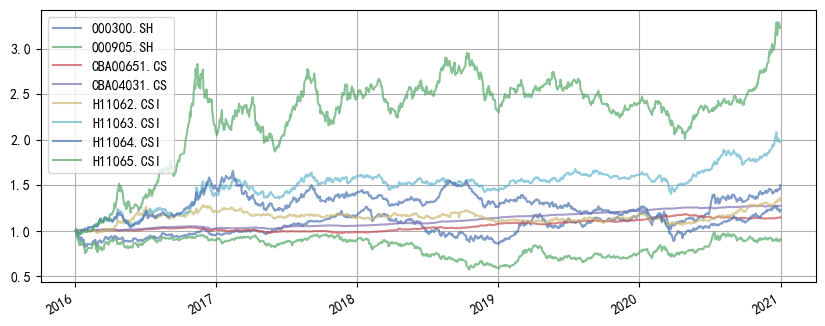

In [5]:
asset_df = pd.DataFrame()

for asset, asset_obj in asset_dict.items():
    asset_obj.setIdDate(date_range_dt[0], date_range_dt[1])
    asset_df[asset] = asset_obj.getUsableNavData()

(asset_df / asset_df.iloc[0]).plot(figsize=(10,4), grid=True, alpha=0.7)


## 2. 构造宏观因子组合

### 2.1 读入因子原始数据

In [6]:
# 载入因子
from symbol import factor

factor_dict = getFactorData()

print(factor_dict)


{'growth': <component.asset.asset.Asset object at 0x0000022870B0A640>, 'interest': <component.asset.asset.Asset object at 0x0000022874171DF0>, 'inflation': <component.asset.asset.Asset object at 0x0000022874183850>, 'credit': <component.asset.asset.Asset object at 0x0000022874183BB0>}


<AxesSubplot:>

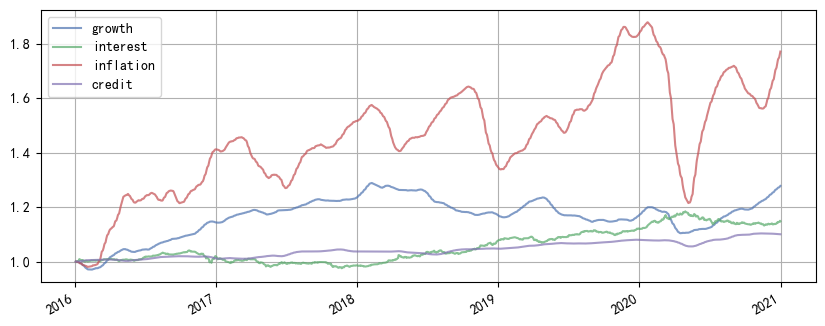

In [7]:
factor_df = pd.DataFrame()

for factor, factor_obj in factor_dict.items():
    factor_obj.setIdDate(date_range_dt[0], date_range_dt[1])
    factor_df[factor] = factor_obj.getUsableNavData()

(factor_df / factor_df.iloc[0]).plot(figsize=(10,4), grid=True, alpha=0.7)

### 2.2 因子模拟组合的构建和回测
构建因子模拟组合，使该组合只对某一个因子有暴露，检查回测结果

In [8]:
# 计算归一化因子暴露
factor_exposure_alg = FactorExposureAlg('factor_exposure_alg')
id_date = datetime(2019, 8, 31)

# 向前取多少数据用于计算
look_back = constant_svc.DAY_OF_MONTH*12

# 为资产和因子设置日期
for asset_obj in asset_dict.values():
    asset_obj.setIdDate(id_date, look_back)
for factor_obj in factor_dict.values():
    factor_obj.setIdDate(id_date, look_back)

asset_data = {asset: asset_obj.getUsableReturnData() for asset, asset_obj in asset_dict.items()}
factor_data = {factor: factor_obj.getUsableReturnData() for factor, factor_obj in factor_dict.items()}


# print('asset_data: \n', pd.DataFrame(asset_data).head())
# print('factor_data: \n', pd.DataFrame(factor_data).head())


alg_base.py-line19 INFO: alg factor_exposure_alg: init args


In [9]:
# v1 一元回归
# exposure_df_v1 = factor_exposure_alg.getFatorExposureFrame(asset_data, factor_data)
# print('exposure_df_v1:\n ', exposure_df_v1)

# print('*' * 50)
# v2 多元回归
exposure_df_v2 = factor_exposure_alg.getFatorExposureFrameV2(asset_data, factor_data)
print('exposure_df_v2:\n ', exposure_df_v2)


exposure_df_v2:
                 growth  interest  inflation    credit
000300.SH    1.271827 -1.450601  -0.584010 -1.326547
000905.SH    1.805026 -1.506842  -1.301327 -1.071225
CBA00651.CS -0.589797  1.237596  -0.517103  0.562100
CBA04031.CS -0.627916  0.735612  -0.552263  0.436715
H11062.CSI  -1.079683  0.691529   0.290823  0.779864
H11063.CSI  -0.278078  0.139437   0.446027 -0.754227
H11064.CSI  -0.332741  0.223285   0.200593  1.542821
H11065.CSI  -0.168638 -0.070016   2.017259 -0.169501


In [10]:
factor_portfolio_alg = FactorPortfolioAlg('factor_portfolio_alg')

# factor_mimicking_portfolio_v1 = factor_portfolio_alg.getFactorMimickingPortfolio(asset_data, factor_data, ols_mode='v1')
# print('factor_mimicking_portfolio_v1: \n', factor_mimicking_portfolio_v1)
# print(factor_mimicking_portfolio_v1.sum())

# print('*' * 50)

factor_mimicking_portfolio_v2 = factor_portfolio_alg.getFactorMimickingPortfolio(asset_data, factor_data, ols_mode='v2')
print('factor_mimicking_portfolio_v2: \n', factor_mimicking_portfolio_v2)
print(factor_mimicking_portfolio_v2.sum())

sys.exit(1)


alg_base.py-line19 INFO: alg factor_portfolio_alg: init args
alg_base.py-line19 INFO: alg : init args


factor_mimicking_portfolio_v2: 
                growth  interest  inflation    credit
000300.SH   -0.070404 -0.006609   0.128740 -0.065833
000905.SH    0.371276 -0.022145  -0.113798  0.073039
CBA00651.CS  1.577457  1.835922   0.496537 -0.048991
CBA04031.CS -1.821117 -1.778482  -1.008863  0.061900
H11062.CSI  -0.224687 -0.007312   0.237672  0.044391
H11063.CSI  -0.192305  0.147549  -0.048779 -0.541237
H11064.CSI   0.177602 -0.116461   0.023655  0.367564
H11065.CSI   0.182177 -0.052462   0.284838  0.109167
growth       3.225198e-14
interest    -2.910172e-14
inflation    2.869927e-14
credit       2.610412e-14
dtype: float64


SystemExit: 1

c:\Users\yuans\Anaconda3\envs\py38\lib\site-packages\IPython\core\interactiveshell.py:3406: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
backtest_args = {
    'date_range': [[2015, 1, 1], [2020, 12, 31]], 
    'frequency': 'monthly', 
    'cash': 1e4, 
    }

strategy_args = {
    'indicator_period': constant_svc.DAY_OF_MONTH*6, 
}

In [ ]:
factor_mimicking_portfolio_nav = pd.DataFrame()
asset_weight_dict = {}
for factor in factor_dict:
    asset_weight = pd.DataFrame()
    my_backtest_manager = BackTestManager(
        FactorMimickingPortfolioStrategy('test', factor, args=strategy_args), # 策略实例
        name = '_', 
        args = backtest_args, 
    )
    my_backtest_manager.backtest()
    factor_mimicking_portfolio_nav[factor] = my_backtest_manager.getDataset().getPositionManager().getHistoricalData().nav

    # 存储结果
    result = {
        'strategy': my_backtest_manager.getDataset().getPositionManager().getHistoricalData(), 
        'assets': my_backtest_manager.getDataset().getGroup('assets').getPositionManager().getHistoricalData(), 
        'orders': my_backtest_manager.getOrderManager().getAllOrders()
    }
    for asset, asset_obj in my_backtest_manager.getDataset().getAllAsset().items():
        result[asset] = asset_obj.getPositionManager().getHistoricalData()

    # writer = pd.ExcelWriter(os.path.join(this_path, 'results_{}.xlsx'.format(factor)))
    # for k, v in result.items():
    #     # print(k)
    #     v.to_excel(writer, k.replace('/', '-'))
    # writer.save()
    # writer.close()

    # weight
    for asset, asset_obj in my_backtest_manager.getDataset().getAllAsset().items():
        asset_weight[asset] = asset_obj.getPositionManager().getHistoricalData().weight
    asset_weight_dict[factor] = asset_weight


alg_base.py-line19 INFO: alg test: init args
alg_base.py-line19 INFO: alg _: init args
alg_base.py-line19 INFO: alg : init args
strategy_base.py-line49 INFO: strategy test: init dataset
backtest_manager.py-line26 INFO: init BackTestManager
backtest_manager.py-line61 INFO: setting date index
backtest_manager.py-line68 INFO: setting init cash
strategy_base.py-line64 INFO: test: init cash
backtest: 100%|██████████| 1462/1462 [00:59<00:00, 24.47days/s]
alg_base.py-line19 INFO: alg test: init args
alg_base.py-line19 INFO: alg _: init args
alg_base.py-line19 INFO: alg : init args
strategy_base.py-line49 INFO: strategy test: init dataset
backtest_manager.py-line26 INFO: init BackTestManager
backtest_manager.py-line61 INFO: setting date index
backtest_manager.py-line68 INFO: setting init cash
strategy_base.py-line64 INFO: test: init cash
backtest: 100%|██████████| 1462/1462 [01:01<00:00, 23.76days/s]
alg_base.py-line19 INFO: alg test: init args
alg_base.py-line19 INFO: alg _: init args
alg_bas

<AxesSubplot:>

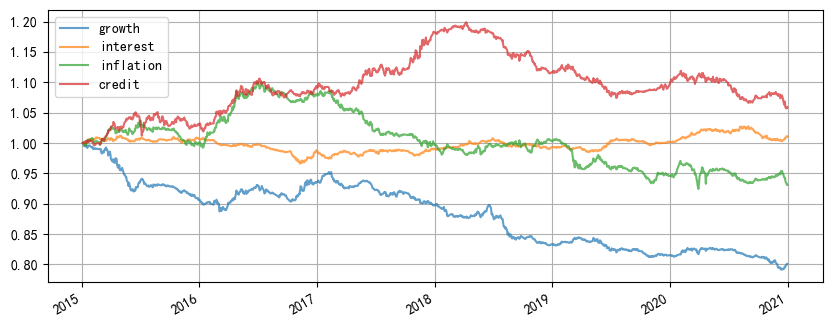

In [ ]:
factor_mimicking_portfolio_nav.plot(figsize=(10,4), grid=True, alpha=0.7)

In [ ]:
factor_mimicking_portfolio_nav.to_csv(os.path.join(this_path, '../data/assets/fmp.csv'))

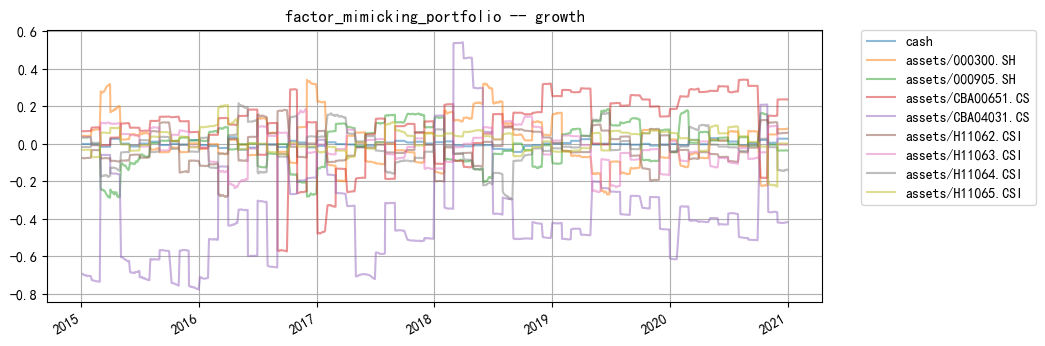

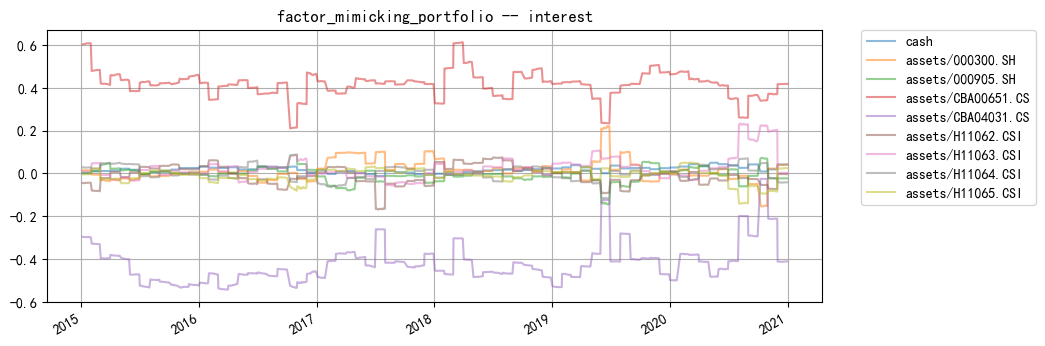

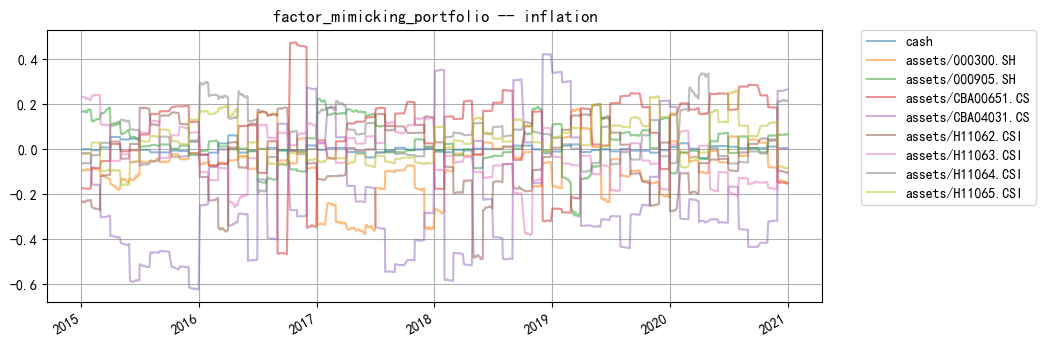

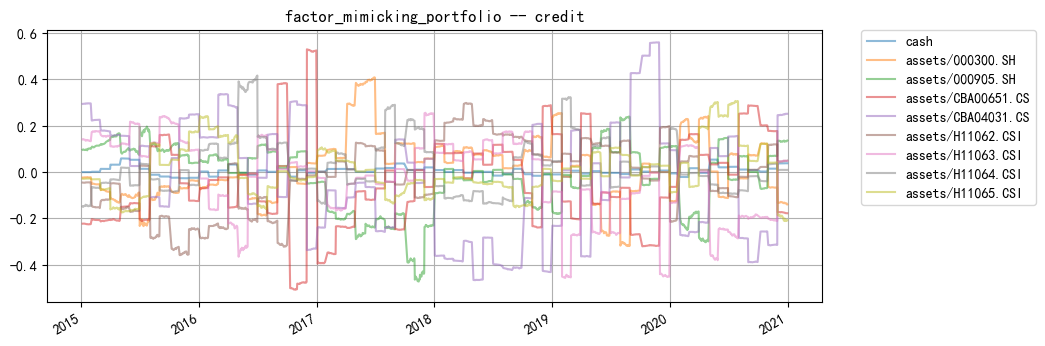

In [ ]:
for factor, weights in asset_weight_dict.items():
    weights.plot(figsize=(10,4), grid=True, alpha=0.5, title='factor_mimicking_portfolio -- {}'.format(factor))
    plt.legend(loc=2, bbox_to_anchor=(1.05,1.0),borderaxespad = 0.)

### 2.3 因子和模拟组合业绩对比

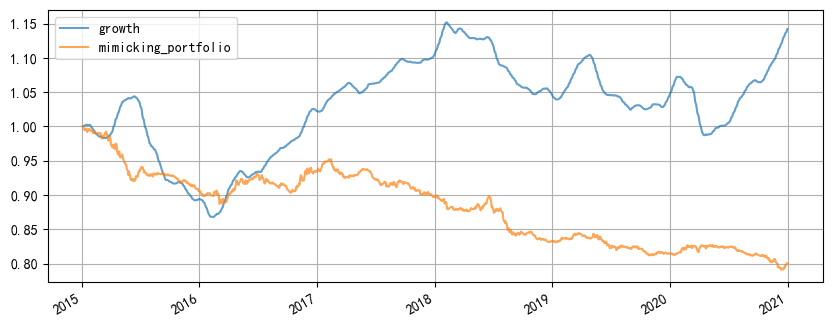

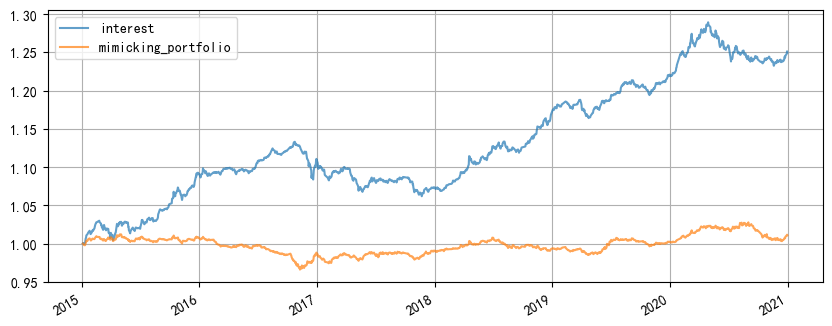

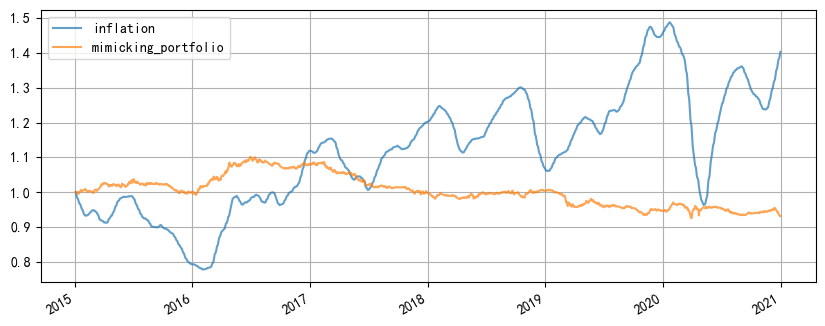

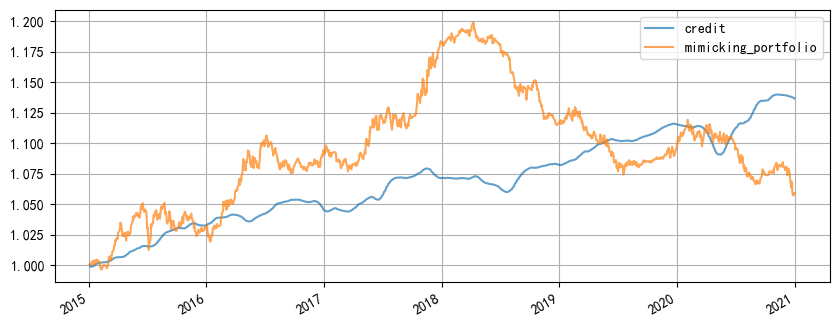

In [ ]:
date_range = [datetime(d[0], d[1], d[2]) for d in backtest_args['date_range']]
for factor, factor_obj in factor_dict.items():
    factor_obj.setIdDate(date_range[0], date_range[1])

    factor_data = factor_obj.getUsableNavData()
    mimicking_portfolio_data = factor_mimicking_portfolio_nav[factor]

    tmp = pd.DataFrame({
        factor: factor_data, 
        'mimicking_portfolio': mimicking_portfolio_data
    })

    (tmp / tmp.iloc[0]).plot(figsize=(10,4), grid=True, alpha=0.7)

使用pca处理得到的因子

In [ ]:
strategy_args['pca'] = True

factor_mimicking_portfolio_nav = pd.DataFrame()
asset_weight_dict = {}
for factor in getFactorData(pca=True):
    asset_weight = pd.DataFrame()
    my_backtest_manager = BackTestManager(
        FactorMimickingPortfolioStrategy('test', factor, args=strategy_args), # 策略实例
        name = '_', 
        args = backtest_args, 
    )
    my_backtest_manager.backtest()
    factor_mimicking_portfolio_nav[factor] = my_backtest_manager.getDataset().getPositionManager().getHistoricalData().nav

    # 存储结果
    result = {
        'strategy': my_backtest_manager.getDataset().getPositionManager().getHistoricalData(), 
        'assets': my_backtest_manager.getDataset().getGroup('assets').getPositionManager().getHistoricalData(), 
        'orders': my_backtest_manager.getOrderManager().getAllOrders()
    }
    for asset, asset_obj in my_backtest_manager.getDataset().getAllAsset().items():
        result[asset] = asset_obj.getPositionManager().getHistoricalData()

    # writer = pd.ExcelWriter(os.path.join(this_path, 'results_{}.xlsx'.format(factor)))
    # for k, v in result.items():
    #     # print(k)
    #     v.to_excel(writer, k.replace('/', '-'))
    # writer.save()
    # writer.close()

    # weight
    for asset, asset_obj in my_backtest_manager.getDataset().getAllAsset().items():
        asset_weight[asset] = asset_obj.getPositionManager().getHistoricalData().weight
    asset_weight_dict[factor] = asset_weight


alg_base.py-line19 INFO: alg test: init args
alg_base.py-line19 INFO: alg _: init args
alg_base.py-line19 INFO: alg : init args
strategy_base.py-line49 INFO: strategy test: init dataset
backtest_manager.py-line26 INFO: init BackTestManager
backtest_manager.py-line61 INFO: setting date index
backtest_manager.py-line68 INFO: setting init cash
strategy_base.py-line64 INFO: test: init cash
backtest: 100%|██████████| 1462/1462 [00:55<00:00, 26.33days/s]
alg_base.py-line19 INFO: alg test: init args
alg_base.py-line19 INFO: alg _: init args
alg_base.py-line19 INFO: alg : init args
strategy_base.py-line49 INFO: strategy test: init dataset
backtest_manager.py-line26 INFO: init BackTestManager
backtest_manager.py-line61 INFO: setting date index
backtest_manager.py-line68 INFO: setting init cash
strategy_base.py-line64 INFO: test: init cash
backtest: 100%|██████████| 1462/1462 [01:18<00:00, 18.69days/s]
alg_base.py-line19 INFO: alg test: init args
alg_base.py-line19 INFO: alg _: init args
alg_bas

<AxesSubplot:>

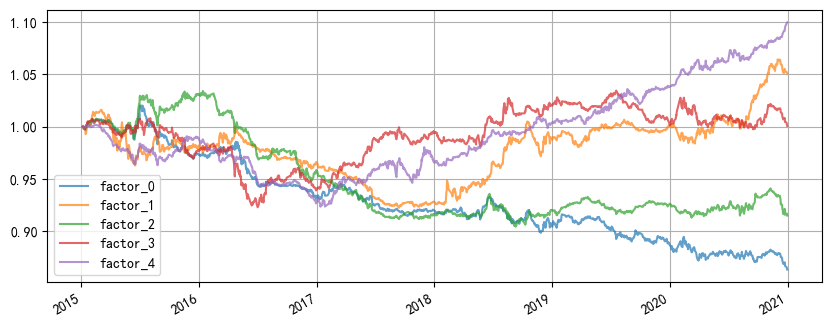

In [ ]:
factor_mimicking_portfolio_nav.plot(figsize=(10,4), grid=True, alpha=0.7)

In [ ]:
factor_mimicking_portfolio_nav.to_csv(os.path.join(this_path, '../data/assets/pca_fmp.csv'))